In [ ]:
!pip install fasttext
!pip install gdown
!pip install n_sphere
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313496 sha256=df7da0c55ff6f9e657d76a03628c3d6d17c9772f0881cbe74f934bbdb13bb991
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

***The following Correlation method is used to calculate all the results mentioned in the paper. To replicate, please download the languages based on the below code, adjust per the number of embeddings needed and run the code***

In [4]:
#Hindi
#!wget "https://vectors.nlpl.eu/repository/20/48.zip"
#!unzip 48.zip

#Russian
#!wget "https://vectors.nlpl.eu/repository/20/65.zip"
#!unzip 65.zip

#English
!wget "https://vectors.nlpl.eu/repository/20/40.zip"
!unzip 40.zip

--2025-04-07 18:51:47--  https://vectors.nlpl.eu/repository/20/40.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.200, 2001:700:112::200
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3033545506 (2.8G) [application/zip]
Saving to: ‘40.zip’

40.zip              100%[===================>]   2.83G  18.9MB/s    in 2m 33s  

2025-04-07 18:54:21 (19.0 MB/s) - ‘40.zip’ saved [3033545506/3033545506]

Archive:  40.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [5]:
def process_text_file(file_path):
    words = []
    vectors = []
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            next(file)
            for line in file:
                line #ignore the first line
                if line:  # Skip empty lines
                    parts = line.split(maxsplit=1) #split only at the first space
                    if len(parts) == 2:
                        words.append(parts[0])
                        vectors.append(parts[1])
                        # Assuming the rest of the line is a space-separated vector
    #print(f"Error: File '{file_path}' not found.")
    return words, vectors

In [6]:
words, vectors = process_text_file('model.txt')

In [7]:
vectors = vectors[:10000]
words = words[:10000]

In [8]:
import numpy as np
word_embeddings_nn = [np.array(v.split()) for v in vectors]

In [10]:
print(len(word_embeddings_nn))

10000


In [9]:
words[123]

'well'

In [11]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 21.2 MB/s eta 0:00:00


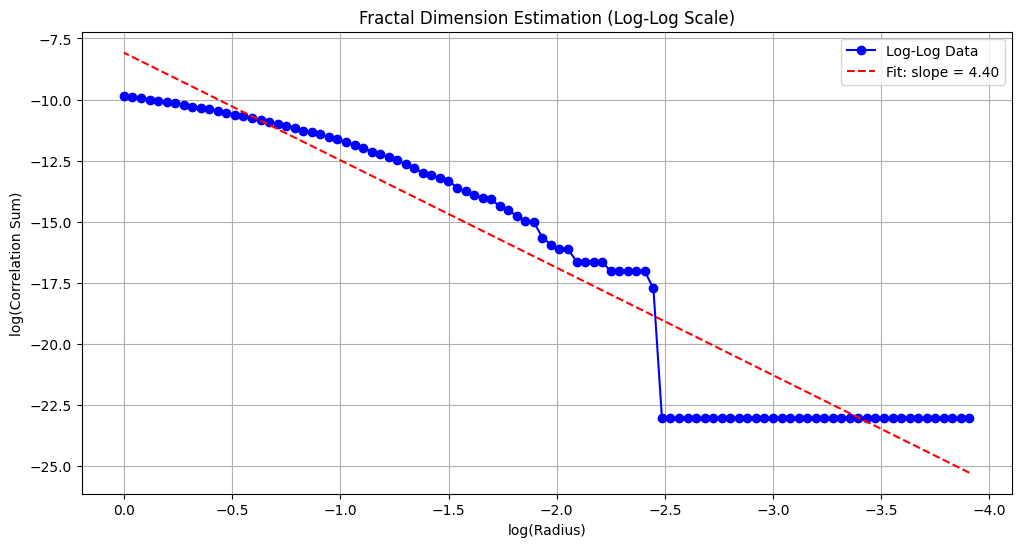

Estimated Fractal Dimension: 4.40


In [14]:
#Implementation as per fractal dimension - James Theiler paper and the below paper as well.
#Inside Average pointwise mass algorithms heading in page 8, C(N,r) = 1/N Summation(B(r)) where B(r) = box of radius or circle of radius
#Then in page 12, under Implementation of correlation algorithm it is given as - log(C(N,r))/log r - which is implemented here.

#Radius values given in the paper.

'''
Paper - https://www.mdpi.com/2504-3110/8/10/603#B27-fractalfract-08-00603 - Fractal Analysis of GPT-2 Token Embedding Spaces: Stability and Evolution of Correlation Dimension
Calculating the correlation dimension using Grassberger–Procaccia algorithm.
Algorithm 1 Grassberger–Procaccia algorithm for estimating 𝐷2
.
1: Compute the pairwise distances 𝑟𝑖𝑗=∥𝑥𝑖−𝑥𝑗∥ for all the points in the dataset.
2: For a range of 𝜖 values, compute the correlation sum: 𝐶(𝜖)=2𝑁(𝑁−1)∑𝑖<𝑗Θ(𝜖−𝑟𝑖𝑗)
3: Plot log𝐶(𝜖) against log𝜖.
4: Estimate 𝐷2 as the slope of the linear region in this plot.
'''

import numpy as np
import faiss
import math
import matplotlib.pyplot as plt

def boxcounting_dimension_faiss(data, max_radius, num_radii=40, k=100):
    """
    Compute the correlation sum for a range of radii using FAISS.

    :param data: np.array of embeddings (n_samples, n_features)
    :param max_radius: maximum search radius
    :param num_radii: number of radius intervals (logarithmic scale)
    :param k: number of nearest neighbors to consider
    :return: radii (array), correlation sums (array)
    """
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    # Build the FAISS index
    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    # Generate radii in logarithmic scale
    #radii = np.logspace(-1, np.log2(max_radius), num_radii)
    #radii = np.linspace(max_radius,0.1, num_radii)
    radii = np.logspace(math.log(0.0201, 10), math.log(1, 10), 100)
    sum = np.zeros(100)

    # Perform range search for all radii
    for i, r in enumerate(radii):
        lims, dists, _ = index.range_search(data, r)

        total_count = lims[-1] - n_samples

        #sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10) - Average pointwise
        sum[i] = max(total_count / (n_samples*(n_samples-1)), 1e-10)
        #sum[i] = total_count
    return radii, sum


def estimate_fractal_dimension(radii, sum):
    """
    Estimate the fractal dimension using the log-log slope of radii and correlation sums.

    :param radii: array of radii
    :param sum: array of correlation sums
    :return: estimated fractal dimension
    """
    # Filter out invalid values
    valid_indices = sum > 0
    log_radii = np.log(radii[valid_indices])
    log_sum = np.log(sum[valid_indices])

    if len(log_radii) < 2:
        return np.nan  # Not enough points to compute a slope

    # Perform linear regression on log-log scale
    coeffs = np.polyfit(log_radii, log_sum, deg=1)
    return coeffs[0], log_radii, log_sum
if __name__ == "__main__":

    n_samples, n_features = len(word_embeddings_nn), len(word_embeddings_nn)
    embeddings_list = word_embeddings_nn

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    # Set the maximum radius (based on the feature space dimensionality)
    max_radius = 1
    num_radii = 60

    # Compute correlation dimensio
    radii, sum = boxcounting_dimension_faiss(word_embeddings_fractal, max_radius, num_radii)

    # Estimate the fractal dimension
    fractal_dim, log_radii, log_sum = estimate_fractal_dimension(radii, sum)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(log_radii, log_sum, 'bo-', label="Log-Log Data")
    plt.plot(log_radii, np.poly1d(np.polyfit(log_radii, log_sum, 1))(log_radii), 'r--',
             label=f"Fit: slope = {fractal_dim:.2f}")
    plt.xlabel('log(Radius)')
    plt.ylabel('log(Correlation Sum)')
    plt.title('Fractal Dimension Estimation (Log-Log Scale)')
    plt.legend()
    plt.grid(True)

    plt.gca().invert_xaxis()

    plt.show()

    # Print final estimated fractal dimension
    print(f"Estimated Fractal Dimension: {fractal_dim:.2f}")

[ 6.93147181e-01  6.76914445e-01  6.60413853e-01  6.43636418e-01
  6.26572690e-01  6.09212729e-01  5.91546068e-01  5.73561674e-01
  5.55247909e-01  5.36592483e-01  5.17582406e-01  4.98203931e-01
  4.78442498e-01  4.58282664e-01  4.37708035e-01  4.16701181e-01
  3.95243554e-01  3.73315382e-01  3.50895564e-01  3.27961547e-01
  3.04489191e-01  2.80452613e-01  2.55824019e-01  2.30573508e-01
  2.04668855e-01  1.78075266e-01  1.50755091e-01  1.22667509e-01
  9.37681595e-02  6.40087198e-02  3.33364203e-02  1.69348051e-03
 -3.09835455e-02 -6.47645354e-02 -9.97266979e-02 -1.35955636e-01
 -1.73546610e-01 -2.12606046e-01 -2.53253353e-01 -2.95623124e-01
 -3.39867826e-01 -3.86161110e-01 -4.34701928e-01 -4.85719703e-01
 -5.39480880e-01 -5.96297355e-01 -6.56537435e-01 -7.20640321e-01
 -7.89135556e-01 -8.62669640e-01 -9.42043228e-01 -1.02826440e+00
 -1.12262716e+00 -1.22683094e+00 -1.34316993e+00 -1.47484776e+00
 -1.62653235e+00 -1.80541156e+00 -2.02341371e+00 -2.30258509e+00] [ -8.77366426  -8.806510

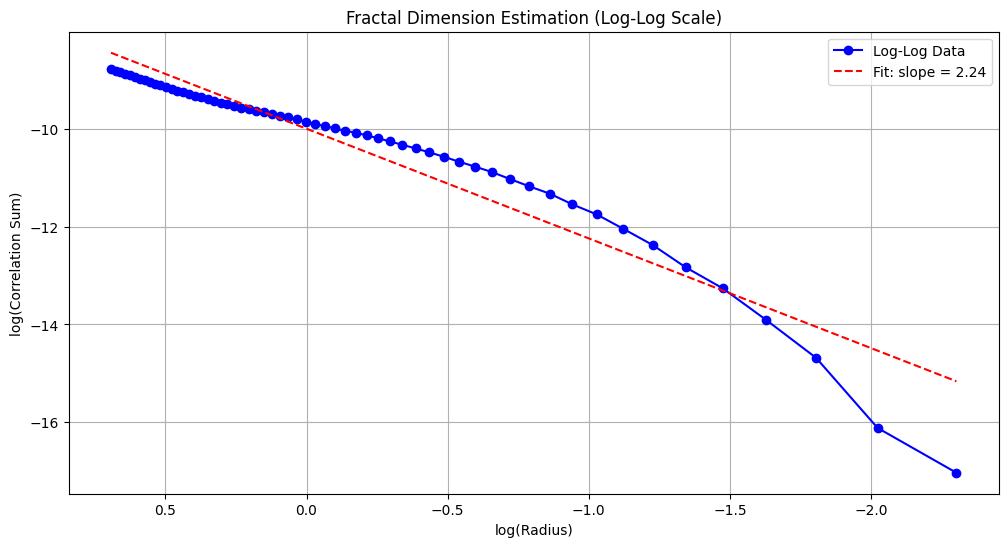

Estimated Fractal Dimension: 2.24


In [13]:
#Using spheres
#This code can be executed.

import numpy as np
import faiss
import matplotlib.pyplot as plt

def correlation_dimension_faiss(data, max_radius, num_radii,k=100):
    """
    Calculate the correlation dimension of the dataset using Faiss.

    :param data: numpy array of shape (n_samples, n_features)
    :param max_radius: maximum radius for correlation sum calculation
    :param num_radii: number of radii to use for calculation
    :return: radii, correlation_sum
    """
    n_samples, n_features = data.shape

    # Convert data to float32 (required by Faiss)
    data = data.astype(np.float32)

    # Create Faiss index
    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    # Generate radii
    #radii = np.logspace(-1, np.log10(max_radius), num_radii)
    radii = np.linspace(max_radius,0.1, num_radii)

    # Calculate correlation sum for each radius
    correlation_sum = np.zeros(num_radii)
    for i, r in enumerate(radii):
        # Count number of neighbors within radius r for each point
        #print(index.range_search(data, r**2))
        #neighbors = index.range_search(data, r**2)  # Faiss uses squared distances
        #correlation_sum[i] = len(neighbors) / (n_samples * (n_samples - 1))

        distances, _ = index.search(data, k)

        # Count number of neighbors within radius r for each point
        count_within_radius = np.sum(distances < r, axis=1) - 1  # subtract 1 to exclude the point itself
        total_count = np.sum(count_within_radius)
        correlation_sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10)

    return radii, correlation_sum

def estimate_fractal_dimension(radii, correlation_sum):
    """
    Estimate fractal dimension from the slope of log-log plot.

    :param radii: array of radii used
    :param correlation_sum: array of correlation sums
    :return: estimated fractal dimension
    """
    log_radii = np.log(radii)
    log_correlation_sum = np.log(correlation_sum)

    print(log_radii,log_correlation_sum)
    # Linear regression to find slope
    coeffs = np.polyfit(log_radii, log_correlation_sum, deg=1)
    return coeffs[0],log_radii,log_correlation_sum

if __name__ == "__main__":

    n_samples, n_features = len(word_embeddings_nn), len(word_embeddings_nn)
    embeddings_list = word_embeddings_nn

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    # Set the maximum radius (based on the feature space dimensionality)
    max_radius = 2
    num_radii = 60

    # Compute correlation dimensio
    radii, sum = correlation_dimension_faiss(word_embeddings_fractal, max_radius, num_radii)

    # Estimate the fractal dimension
    fractal_dim, log_radii, log_sum = estimate_fractal_dimension(radii, sum)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(log_radii, log_sum, 'bo-', label="Log-Log Data")
    plt.plot(log_radii, np.poly1d(np.polyfit(log_radii, log_sum, 1))(log_radii), 'r--',
             label=f"Fit: slope = {fractal_dim:.2f}")
    plt.xlabel('log(Radius)')
    plt.ylabel('log(Correlation Sum)')
    plt.title('Fractal Dimension Estimation (Log-Log Scale)')
    plt.legend()
    plt.grid(True)

    plt.gca().invert_xaxis()

    plt.show()

    # Print final estimated fractal dimension
    print(f"Estimated Fractal Dimension: {fractal_dim:.2f}")

In [ ]:

words_to_analyze1 = [
    "Set", "Run", "Go", "Take", "Get", "Make", "Put", "Stand", "Hold", "Turn",
    "Break", "Fall", "Cut", "Pass", "Bring", "Do", "Catch", "Draw", "Leave", "Keep",
    "Pay", "Build", "Lead", "Raise", "Move", "Close", "Meet", "Reach", "Send", "Drive",
    "Throw", "Read", "Walk"
]

words_to_analyze2=["flask","flatbed","flatware","fleur-de-lis","trainer","flintlock","flooring","floorboard","florist","flotilla","mole","saddle","skin","hair","crop","mille"]



['set', 'run', 'go', 'take', 'get', 'make', 'put', 'stand', 'hold', 'turn', 'break', 'fall', 'cut', 'pass', 'bring', 'do', 'catch', 'draw', 'leave', 'keep', 'pay', 'build', 'lead', 'raise', 'move', 'close', 'meet', 'reach', 'send', 'drive', 'throw', 'read', 'walk']
